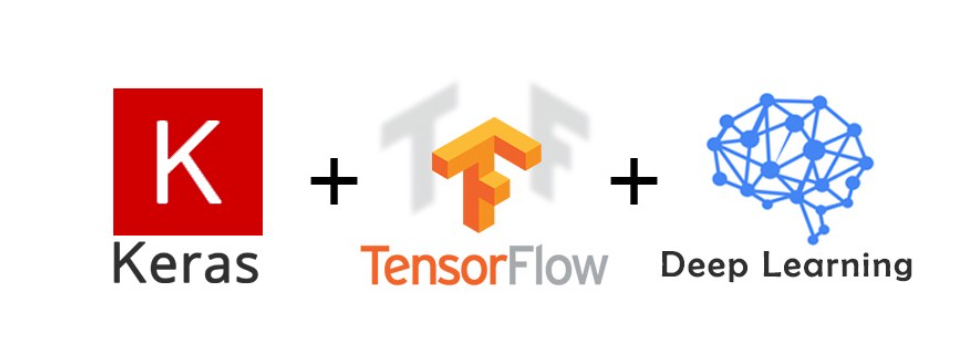

In [2]:
from IPython.display import Image
Image(filename='Capture.png')

### Predicting Loan Defaults using Deep Learning with Keras & Tensorflow

# import libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential   #pip uninstall h5py #conda install -c anaconda h5py
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from pickle import dump, load

%matplotlib inline

In [23]:
df = pd.read_csv(r"C:/Users/Nageswaran B/Documents/machine_learning/machine_learning_project/simplilearn/Lending_Club_Loan_Data_Analysis/loan_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [24]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


### The “Purpose” data column is categorical, “Annual income” is log value, which needs to be converted back to exponential. The rest of the columns are numerical. Transpose the data frame to understand the std and mean.

In [25]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
credit.policy,9578.0,0.804970,0.396245,0.000000,1.000000,1.000000,1.000000,1.000000e+00
int.rate,9578.0,0.122640,0.026847,0.060000,0.103900,0.122100,0.140700,2.164000e-01
installment,9578.0,319.089413,207.071301,15.670000,163.770000,268.950000,432.762500,9.401400e+02
log.annual.inc,9578.0,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,1.452835e+01
dti,9578.0,12.606679,6.883970,0.000000,7.212500,12.665000,17.950000,2.996000e+01
fico,9578.0,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,8.270000e+02
days.with.cr.line,9578.0,4560.767197,2496.930377,178.958333,2820.000000,4139.958333,5730.000000,1.763996e+04
revol.bal,9578.0,16913.963876,33756.189557,0.000000,3187.000000,8596.000000,18249.500000,1.207359e+06
revol.util,9578.0,46.799236,29.014417,0.000000,22.600000,46.300000,70.900000,1.190000e+02
inq.last.6mths,9578.0,1.577469,2.200245,0.000000,0.000000,1.000000,2.000000,3.300000e+01


### Check the label “no.fully.paid” distribution in the dataset.

In [26]:
df['not.fully.paid'].isnull().mean()
df.groupby('not.fully.paid')['not.fully.paid'].count()/len(df)

not.fully.paid
0    0.839946
1    0.160054
Name: not.fully.paid, dtype: float64

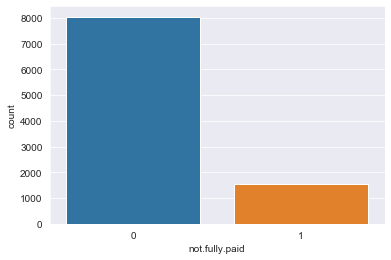

In [27]:
sns.set_style('darkgrid')
sns.countplot(x='not.fully.paid', data=df)

### The above shows, This dataset is highly imbalanced and includes features that make this problem more challenging. If we do model training with this data, the prediction will be biased since the “not.fully.paid =0 “ has 83.9% filled, and only 16% is the “not.fully.paid=1”

### There were multiple methods to handle imbalanced data; here are a few techniques.

### 1. Resample the training set

### There are two approaches to make a balanced dataset out of an imbalanced one are under-sampling and over-sampling.

### Under-sampling

### Under-sampling balances the dataset by reducing the size of the abundant class. This method is used when the quantity of data is sufficient.

### Over-sampling

### Oversampling is used when the quantity of data is insufficient. It tries to balance the dataset by increasing the size of rare samples.

### There is no absolute advantage of one resampling method over another.

Random over-sampling:
0    8045
1    8045
Name: not.fully.paid, dtype: int64


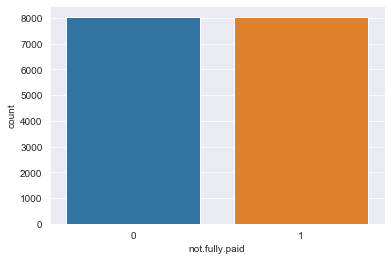

In [29]:
count_class_0, count_class_1 = df['not.fully.paid'].value_counts()
df_0 = df[df['not.fully.paid'] == 0]
df_1 = df[df['not.fully.paid'] == 1]
df_1_over = df_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_0, df_1_over], axis=0)
print('Random over-sampling:')
print(df_test_over['not.fully.paid'].value_counts())

sns.set_style('darkgrid')
sns.countplot(x='not.fully.paid', data=df_test_over)

# Exploratory Data Analysis

Text(0.5, 0, 'FICO')

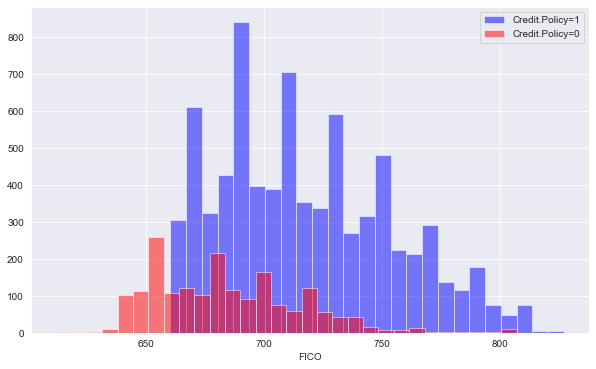

In [30]:
plt.figure(figsize=(10,6))
df[df['credit.policy']==1]['fico'].hist(alpha=0.5,color='blue',bins=30,label='Credit.Policy=1')
df[df['credit.policy']==0]['fico'].hist(alpha=0.5,color='red',bins=30,label='Credit.Policy=0')
plt.legend()
plt.xlabel('FICO')

Text(0.5, 0, 'FICO')

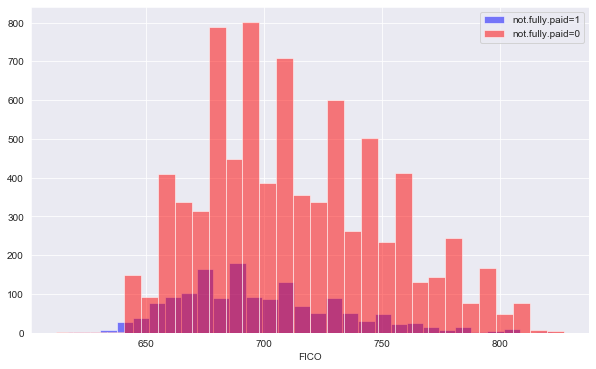

In [31]:
plt.figure(figsize=(10,6))
df[df['not.fully.paid']==1]['fico'].hist(alpha=0.5,color='blue',bins=30,label='not.fully.paid=1')
df[df['not.fully.paid']==0]['fico'].hist(alpha=0.5,color='red',bins=30,label='not.fully.paid=0')
plt.legend()
plt.xlabel('FICO')

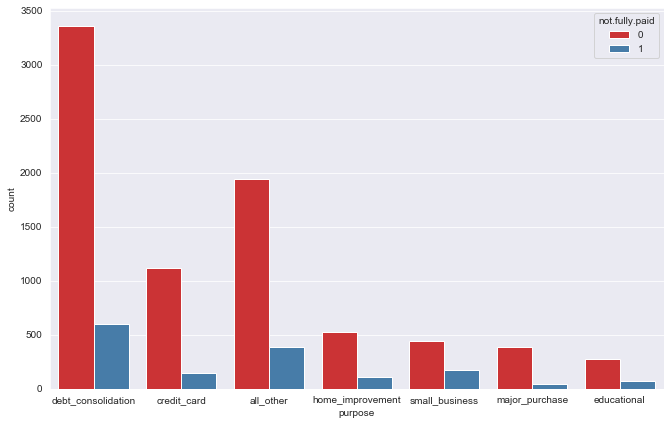

In [32]:
plt.figure(figsize=(11,7))
sns.countplot(x='purpose',hue='not.fully.paid',data=df,palette='Set1')

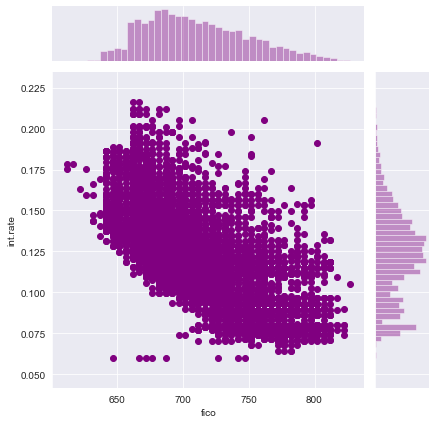

In [33]:
sns.jointplot(x='fico',y='int.rate',data=df,color='purple')

### To compare the trend between not.fully.paid and credit.policy, create seaborn implot.

<Figure size 792x504 with 0 Axes>

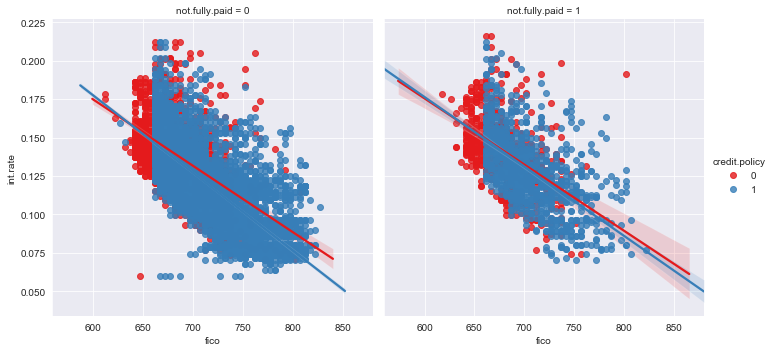

In [34]:
plt.figure(figsize=(11,7))
sns.lmplot(y='int.rate',x='fico',data=df,hue='credit.policy',
           col='not.fully.paid',palette='Set1')

### The above visuals gave us an idea of how the data is and what we will work with. Nest step is to prepare the data for model training and test as the first step converts the categorical values to numeric. Here in this dataset “purpose” column is a critical data point for the model as per our analysis above, and it is categorical.

In [35]:
col_fea = ['purpose']
final_data = pd.get_dummies(df_test_over,columns=col_fea,drop_first=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16090 entries, 0 to 8012
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit.policy               16090 non-null  int64  
 1   int.rate                    16090 non-null  float64
 2   installment                 16090 non-null  float64
 3   log.annual.inc              16090 non-null  float64
 4   dti                         16090 non-null  float64
 5   fico                        16090 non-null  int64  
 6   days.with.cr.line           16090 non-null  float64
 7   revol.bal                   16090 non-null  int64  
 8   revol.util                  16090 non-null  float64
 9   inq.last.6mths              16090 non-null  int64  
 10  delinq.2yrs                 16090 non-null  int64  
 11  pub.rec                     16090 non-null  int64  
 12  not.fully.paid              16090 non-null  int64  
 13  purpose_credit_card         1609

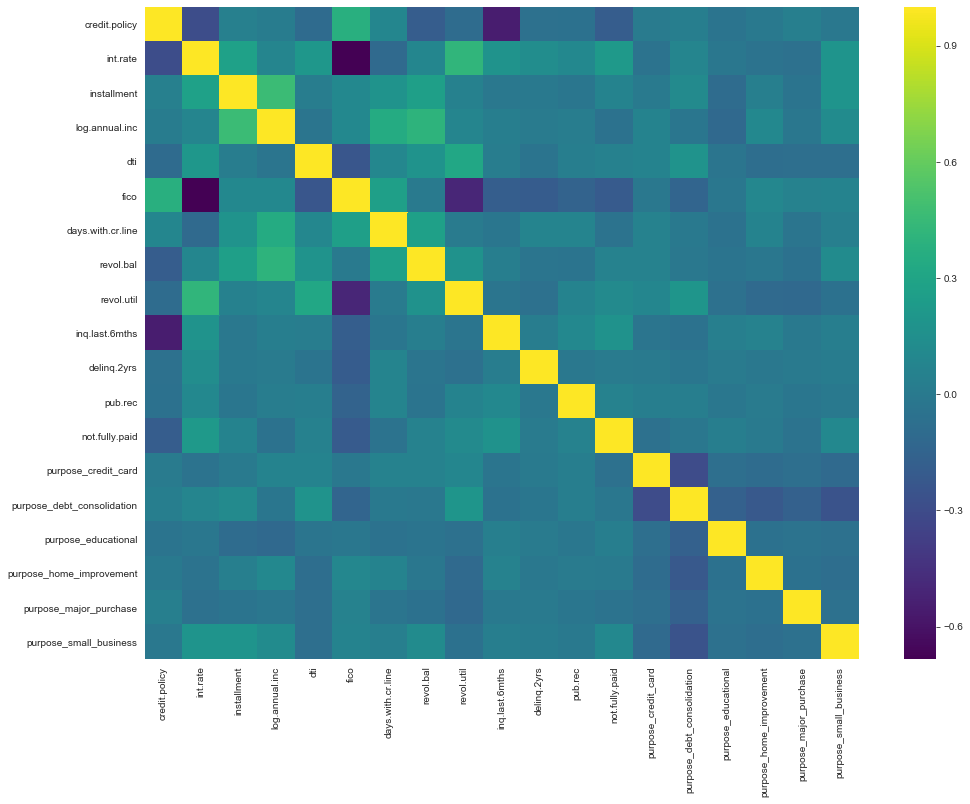

In [36]:
final_data.corr()
plt.figure(
        figsize=[16,12]
)
sns.heatmap(
        data=final_data.corr(), 
        cmap='viridis', 
        annot=False, 
        fmt='.2g'
)

### We only focus on the grids of yellow or very light green. After comparing with the feature description again, I decided to drop:’revol.bal’, ‘days.with.cr.line’, ‘installment’, ‘revol.bal’
### revol.bal, day.with.cr.line, installment can represent by annual income. revol.util can represent by int.rate.

# Modeling

### Deep Learning Implementation

### Finally, do the train test split and fit the model with the data shape we created above. since there are 19 features, I chose the first layer of the neural network with 19 nodes.

In [37]:
to_train = final_data[final_data['not.fully.paid'].isin([0,1])]
to_pred = final_data[final_data['not.fully.paid'] == 2]

X = to_train.drop('not.fully.paid', axis=1).values
y = to_train['not.fully.paid'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 101)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()

model.add(
        Dense(19, activation='relu')
)

model.add(
        Dense(10, activation='relu')
)

model.add(
        Dense(5, activation='relu')
)


model.add(
        Dense(1, activation='sigmoid')
)

model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy']
)

early_stop = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=25
)

model.fit(
        X_train, 
        y_train, 
        epochs=200, 
        batch_size=256, 
        validation_data=(X_test, y_test),
         callbacks=[early_stop]
)

Epoch 1/200
44/44 [==============================] - 1s 5ms/step - loss: 0.6907 - accuracy: 0.5401 - val_loss: 0.6884 - val_accuracy: 0.5844
Epoch 2/200
44/44 [==============================] - 0s 2ms/step - loss: 0.6830 - accuracy: 0.6041 - val_loss: 0.6794 - val_accuracy: 0.6002
Epoch 3/200
44/44 [==============================] - 0s 1ms/step - loss: 0.6708 - accuracy: 0.6135 - val_loss: 0.6677 - val_accuracy: 0.6051
Epoch 4/200
44/44 [==============================] - 0s 1ms/step - loss: 0.6580 - accuracy: 0.6145 - val_loss: 0.6575 - val_accuracy: 0.6105
Epoch 5/200
44/44 [==============================] - 0s 1ms/step - loss: 0.6491 - accuracy: 0.6203 - val_loss: 0.6530 - val_accuracy: 0.6130
Epoch 6/200
44/44 [==============================] - 0s 1ms/step - loss: 0.6446 - accuracy: 0.6230 - val_loss: 0.6517 - val_accuracy: 0.6169
Epoch 7/200
44/44 [==============================] - 0s 2ms/step - loss: 0.6424 - accuracy: 0.6220 - val_loss: 0.6511 - val_accuracy: 0.6109
Epoch 8/200
4

# Model Evaluation and Validation

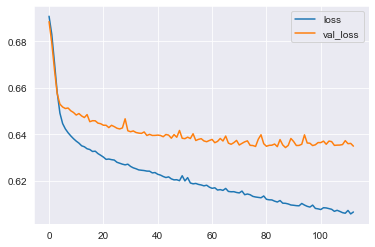

In [38]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

### This validation result, the Loss plot, shows us the model is overfitted.

In [42]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

print(
        confusion_matrix(y_test,predictions), 
        '\n', 
        classification_report(y_test,predictions)
)

[[1655  782]
 [ 972 1418]] 
               precision    recall  f1-score   support

           0       0.63      0.68      0.65      2437
           1       0.64      0.59      0.62      2390

    accuracy                           0.64      4827
   macro avg       0.64      0.64      0.64      4827
weighted avg       0.64      0.64      0.64      4827



### The model’s overall f1-score for accuracy is 0.65. Still, there are type 2 errors (972) in the prediction.

# Model Refinement

### Two ways of refining the model we will try here. Add Dropout layers to bring down the overfitting OR Lower the cut-off line in binary prediction to reduce the Type 2 error, at the cost of increasing Type 1 error. In the LendingClub case, Type 2 error is the more serious problem because it devastates its balance sheet, while Type 1 error is not a very big deal.

In [43]:
model_new = Sequential()

model_new.add(
        Dense(19, activation='relu')
)

model_new.add(Dropout(0.2))

model_new.add(
        Dense(10, activation='relu')
)

model_new.add(Dropout(0.2))

model_new.add(
        Dense(5, activation='relu')
)

model_new.add(Dropout(0.2))

model_new.add(
        Dense(1, activation='sigmoid')
)

model_new.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['binary_accuracy']
)


model_new.fit(
        X_train, 
        y_train, 
        epochs=200, 
        batch_size=256, 
        validation_data=(X_test, y_test),
         callbacks=[early_stop]
)

Epoch 1/200
44/44 [==============================] - 1s 4ms/step - loss: 0.6912 - binary_accuracy: 0.5380 - val_loss: 0.6896 - val_binary_accuracy: 0.5780
Epoch 2/200
44/44 [==============================] - 0s 2ms/step - loss: 0.6876 - binary_accuracy: 0.5537 - val_loss: 0.6832 - val_binary_accuracy: 0.5927
Epoch 3/200
44/44 [==============================] - 0s 2ms/step - loss: 0.6809 - binary_accuracy: 0.5649 - val_loss: 0.6749 - val_binary_accuracy: 0.6070
Epoch 4/200
44/44 [==============================] - 0s 2ms/step - loss: 0.6735 - binary_accuracy: 0.5788 - val_loss: 0.6666 - val_binary_accuracy: 0.6091
Epoch 5/200
44/44 [==============================] - 0s 2ms/step - loss: 0.6681 - binary_accuracy: 0.5957 - val_loss: 0.6624 - val_binary_accuracy: 0.6070
Epoch 6/200
44/44 [==============================] - 0s 2ms/step - loss: 0.6659 - binary_accuracy: 0.5934 - val_loss: 0.6605 - val_binary_accuracy: 0.6118
Epoch 7/200
44/44 [==============================] - 0s 2ms/step - los

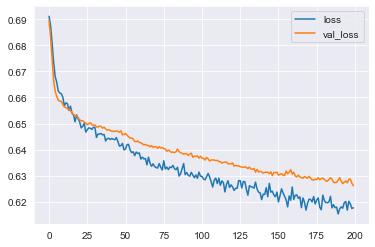

In [44]:
pd.DataFrame(model_new.history.history)[['loss','val_loss']].plot()

### The graph shows that, by adding in Dropout layers, we have reduced the overfitting issue compared with the old model.

In [47]:
# predictions_new = (model_new.predict_proba(X_test) >= 0.2).astype('int')
predictions_new = (model_new.predict(X_test) >= 0.2).astype('int')

# predictions_new=model.predict([testa,testb])

print(
        confusion_matrix(y_test,predictions_new), 
        '\n', 
        classification_report(y_test,predictions_new)
)

[[ 245 2192]
 [  39 2351]] 
               precision    recall  f1-score   support

           0       0.86      0.10      0.18      2437
           1       0.52      0.98      0.68      2390

    accuracy                           0.54      4827
   macro avg       0.69      0.54      0.43      4827
weighted avg       0.69      0.54      0.43      4827



### By changing the cut-off line to 0.2 (default is 0.5), we have dramatically brought down the Type 2 error.